# Diagnostic HW1

In [41]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate
from datetime import datetime
import urllib
import math
from pandas.io.json import json_normalize
import json
import requests

In [2]:
RAW_GRAFFITI = "graffiti_removal.csv"

RAW_BUILDINGS = "vacant_buildings.csv"

RAW_SANITATION = "sanitation_complaints.csv"

RAW_POTHOLES = "potholes_report.csv"

In [3]:
graf_df = pd.read_csv(RAW_GRAFFITI)

vacant_df = pd.read_csv(RAW_BUILDINGS)
vacant_df = vacant_df.rename(index=str, columns=
    {"DATE SERVICE REQUEST WAS RECEIVED": "Creation Date", "SERVICE REQUEST TYPE": "Type of Service Request"})

sanitation_df = pd.read_csv(RAW_SANITATION)

potholes_df = pd.read_csv(RAW_POTHOLES)
potholes_df = potholes_df.rename(index=str, columns=
    {"CREATION DATE": "Creation Date", "TYPE OF SERVICE REQUEST": "Type of Service Request"})

frames = [graf_df, vacant_df, sanitation_df, potholes_df]
combined_df = pd.concat(frames)

In [4]:
num_complaints = {"graffiti" : sum(combined_df["Type of Service Request"] == "Graffiti Removal"), 
                  "potholes" : sum(combined_df["Type of Service Request"] == "Pothole in Street"), 
                  "sanitation" : sum(combined_df["Type of Service Request"] == "Sanitation Code Violation"), 
                  "buildings" : sum(combined_df["Type of Service Request"] == "Vacant/Abandoned Building")} 

In [5]:
total_complaints = 0 
for k, v in num_complaints.items():
    total_complaints += v

# check if total matches length of dataframe
total_complaints == combined_df.shape[0]

True

In [6]:
def plot_complaints(complaint_dict):
    '''
    Funciton to take complaints dictionary and plot the number of requests by type.
    '''
    matplotlib.style.use('ggplot')
    fig, ax = plt.subplots()

    rects = ax.bar(range(len(complaint_dict)), complaint_dict.values(), align='center')

    ax.set_xticks(range(len(complaint_dict)))
    ax.set_xticklabels(complaint_dict.keys(), rotation=90)
    ax.set_title("Number of 311 Calls by Request Type")
    ax.set_ylabel("Number of Complaints")
    ax.set_xlabel("Type of Request")

    # autolabel function found on matplotlib bar chart documentation
    # http://matplotlib.org/examples/api/barchart_demo.html
    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects)
    plt.show()

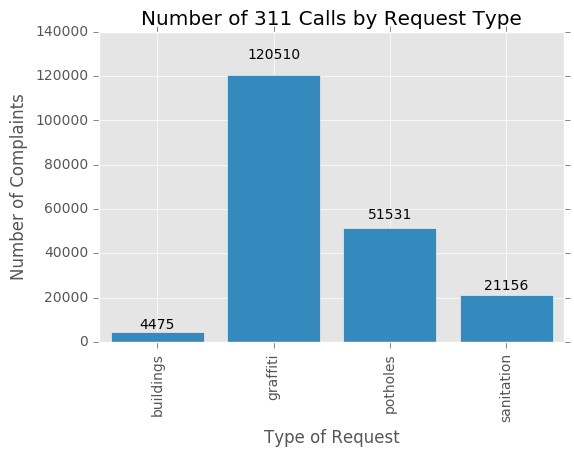

In [7]:
plot_complaints(num_complaints)

In [28]:
complaint_dict = {}
response_dict = {"Graffiti Removal" : [], 
                 "Pothole in Street" : [], 
                 "Sanitation Code Violation" : [], 
                 "Vacant/Abandoned Building" : []}
neighborhood_dict = {}

# function to calculate response time by city found on stackoverflow
# http://stackoverflow.com/questions/8419564/difference-between-two-dates
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    d2 = datetime.strptime(d2, "%m/%d/%Y")
    return abs((d2 - d1).days)

for x in combined_df.values:
    req_type = x[32]
    neighborhood = str(x[7])
    creation_date = str(x[9])
    if str(x[8]) == "nan" and str(x[5]) == "nan":
        response_time = 0
    elif str(x[5]) == "nan":
        response_time = days_between(creation_date, str(x[8]))
    elif str(x[8]) == "nan":
        response_time = days_between(creation_date, str(x[5]))
    response_dict[req_type].append(response_time)
    
    if creation_date in complaint_dict:
        if req_type in complaint_dict[creation_date]:
            complaint_dict[creation_date][req_type] += 1
    else:
        complaint_dict[creation_date] = {"Graffiti Removal" : 0, 
                                "Pothole in Street" : 0, 
                                "Sanitation Code Violation" : 0, 
                                "Vacant/Abandoned Building" : 0}
        if req_type in complaint_dict[creation_date]:
            complaint_dict[creation_date][req_type] += 1
            
    if neighborhood in neighborhood_dict:
        if req_type in neighborhood_dict[neighborhood]:
            neighborhood_dict[neighborhood][req_type] += 1
    else:
        neighborhood_dict[neighborhood] = {"Graffiti Removal" : 0, 
                                "Pothole in Street" : 0, 
                                "Sanitation Code Violation" : 0, 
                                "Vacant/Abandoned Building" : 0}
        if req_type in neighborhood_dict[neighborhood]:
            neighborhood_dict[neighborhood][req_type] += 1

In [9]:
time = np.array(sorted(complaint_dict.keys()))
x = []
graf = []
potholes = []
buildings = []
sanitation = []
for t in time:
    graf.append(complaint_dict[t]["Graffiti Removal"])
    buildings.append(complaint_dict[t]["Vacant/Abandoned Building"])
    potholes.append(complaint_dict[t]["Pothole in Street"])
    sanitation.append(complaint_dict[t]["Sanitation Code Violation"])
    x.append(datetime.strptime(t, "%m/%d/%Y"))

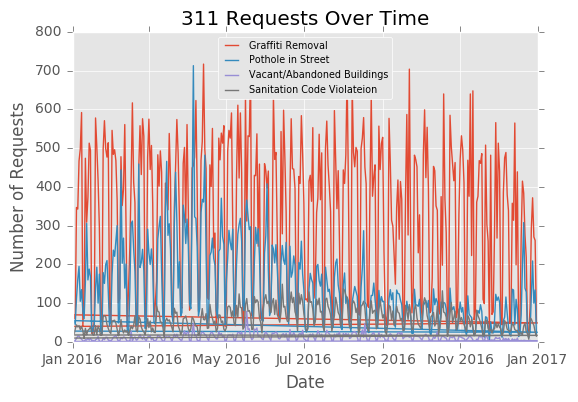

In [10]:
plt.plot(x, graf)
plt.plot(x, potholes)
plt.plot(x, buildings)
plt.plot(x, sanitation)

plt.legend(["Graffiti Removal", 
            "Pothole in Street", 
            "Vacant/Abandoned Buildings", 
            "Sanitation Code Violateion"], 
           loc = "upper center", 
           fancybox = True, 
           fontsize = "x-small")
plt.title("311 Requests Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Requests")
plt.show()

In [11]:
areas = np.array(sorted(neighborhood_dict.keys()))
graf = {}
potholes = {}
buildings = {}
sanitation = {}
for a in areas:
    graf[a] = neighborhood_dict[a]["Graffiti Removal"]
    buildings[a] = neighborhood_dict[a]["Vacant/Abandoned Building"]
    potholes[a] = neighborhood_dict[a]["Pothole in Street"]
    sanitation[a] = neighborhood_dict[a]["Sanitation Code Violation"]

Graffiti Removals
+----------------+------------------------+
|   Neighborhood |   Number of Complaints |
|----------------+------------------------|
|             25 |                    782 |
|             30 |                   4798 |
|             37 |                     49 |
|             12 |                    165 |
|             24 |                   9489 |
|             53 |                    113 |
|             10 |                    140 |
|             74 |                    206 |
|             52 |                    840 |
|             51 |                    266 |
|             26 |                    174 |
|             61 |                   2128 |
|              6 |                   4439 |
|             27 |                    245 |
|              1 |                   1455 |
|             14 |                   3925 |
|             70 |                   1880 |
|             42 |                     99 |
|             39 |                     41 |
|             

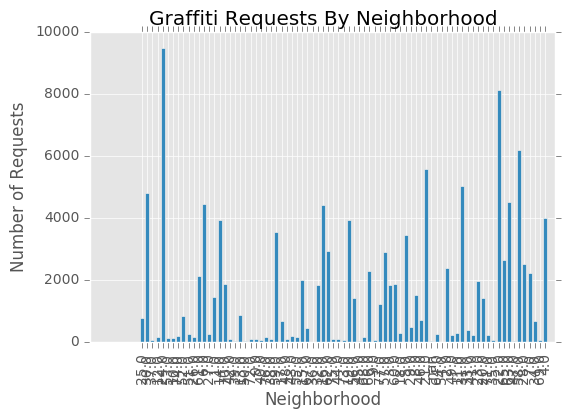

In [12]:
headers = ['Neighborhood', 'Number of Complaints']
print("Graffiti Removals")
print(tabulate([(k, v) for k, v in sorted(graf.items())], headers = headers, tablefmt = "psql"))
print("\n")

plt.bar(range(len(graf)), graf.values(), align='center')
plt.xticks(range(len(graf)), graf.keys(), rotation=90)
plt.title("Neighborhoods with Most Graffiti Requests")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Requests")
plt.show()

Pothole Reports
+----------------+------------------------+
|   Neighborhood |   Number of Complaints |
|----------------+------------------------|
|             25 |                    782 |
|             30 |                   4798 |
|             37 |                     49 |
|             12 |                    165 |
|             24 |                   9489 |
|             53 |                    113 |
|             10 |                    140 |
|             74 |                    206 |
|             52 |                    840 |
|             51 |                    266 |
|             26 |                    174 |
|             61 |                   2128 |
|              6 |                   4439 |
|             27 |                    245 |
|              1 |                   1455 |
|             14 |                   3925 |
|             70 |                   1880 |
|             42 |                     99 |
|             39 |                     41 |
|             13

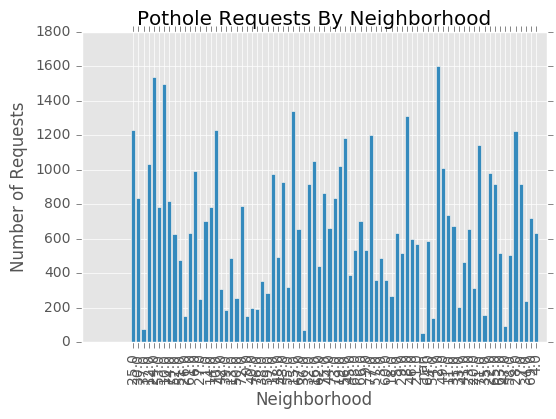

In [13]:
headers = ['Neighborhood', 'Number of Complaints']
print("Pothole Reports")
print(tabulate([(k, v) for k, v in sorted(potholes.items())], headers = headers, tablefmt = "psql"))
print("\n")

plt.bar(range(len(potholes)), potholes.values(), align='center')
plt.xticks(range(len(potholes)), potholes.keys(), rotation=90)
plt.title("Pothole Requests By Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Requests")
plt.show()

Vacant/Abandoned Building Reports
+----------------+------------------------+
|   Neighborhood |   Number of Complaints |
|----------------+------------------------|
|             25 |                    158 |
|             30 |                     38 |
|             37 |                     23 |
|             12 |                      2 |
|             24 |                     36 |
|             53 |                    214 |
|             10 |                      7 |
|             74 |                     19 |
|             52 |                     15 |
|             51 |                     45 |
|             26 |                     82 |
|             61 |                    249 |
|              6 |                     12 |
|             27 |                     72 |
|              1 |                      1 |
|             14 |                     12 |
|             70 |                     72 |
|             42 |                    114 |
|             39 |                     12 

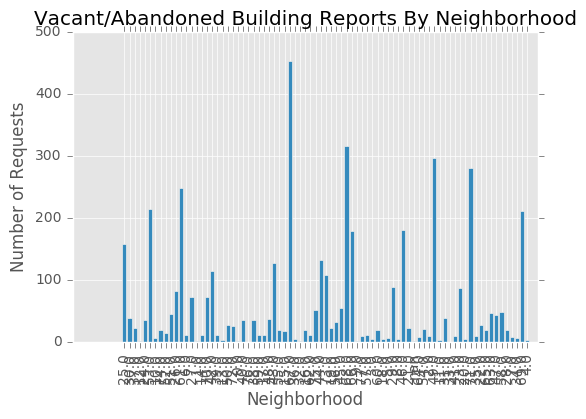

In [14]:
headers = ['Neighborhood', 'Number of Complaints']
print("Vacant/Abandoned Building Reports")
print(tabulate([(k, v) for k, v in sorted(buildings.items())], headers = headers, tablefmt = "psql"))
print("\n")

plt.bar(range(len(buildings)), buildings.values(), align='center')
plt.xticks(range(len(buildings)), buildings.keys(), rotation=90)
plt.title("Vacant/Abandoned Building Reports By Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Requests")
plt.show()

Sanitation Code Requests
+----------------+------------------------+
|   Neighborhood |   Number of Complaints |
|----------------+------------------------|
|              0 |                      0 |
|              1 |                    187 |
|             10 |                    153 |
|             11 |                    130 |
|             12 |                     76 |
|             13 |                    169 |
|             14 |                    299 |
|             15 |                    384 |
|             16 |                    483 |
|             17 |                    158 |
|             18 |                     32 |
|             19 |                    386 |
|              2 |                    472 |
|             20 |                    176 |
|             21 |                    300 |
|             22 |                    731 |
|             23 |                    594 |
|             24 |                    773 |
|             25 |                    788 |
|      

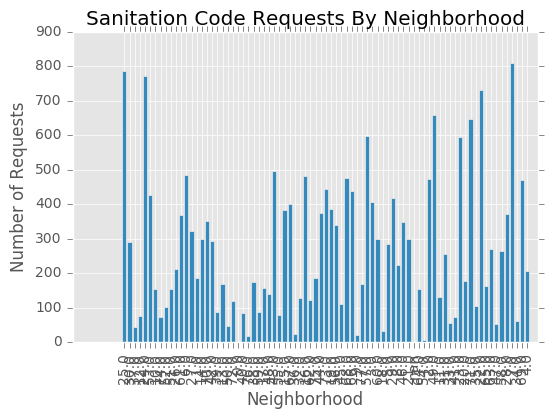

In [20]:
headers = ['Neighborhood', 'Number of Complaints']
print("Sanitation Code Requests")
print(tabulate([(k, v) for k, v in sorted(sanitation.items())], headers = headers, tablefmt = "psql"))
print("\n")

plt.bar(range(len(sanitation)), sanitation.values(), align='center')
plt.xticks(range(len(sanitation)), sanitation.keys(), rotation=90)
plt.title("Sanitation Code Requests By Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Requests")
plt.show()

In [16]:
graf_dict = {"total" : graf_df.shape[0]}
for x in graf_df["What Type of Surface is the Graffiti on?"]:
    if x in graf_dict:
        graf_dict[x] += 1
    else:
        graf_dict[x] = 1
        
vacant_dict = {"total" : vacant_df.shape[0]}
for x in vacant_df["LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD)."]:
    if x in vacant_dict:
        vacant_dict[x] += 1
    else:
        vacant_dict[x] = 1

potholes_dict = {"total" : potholes_df.shape[0]}
for x in potholes_df["MOST RECENT ACTION"]:
    if x in potholes_dict:
        potholes_dict[x] += 1
    else:
        potholes_dict[x] = 1

sanitation_dict = {"total" : sanitation_df.shape[0]}
for x in sanitation_df["What is the Nature of this Code Violation?"]:
    if x in sanitation_dict:
        sanitation_dict[x] += 1
    else:
        sanitation_dict[x] = 1


In [17]:
headers = ['Request Subtype', 'Number of Complaints']
print("Graffiti Complaint Types")
print(tabulate([(k, v) for k, v in graf_dict.items()], headers = headers, tablefmt = "psql"))
print("\n")
print("Vacant Building Complaint Types")
print(tabulate([(k, v) for k, v in vacant_dict.items()], headers = headers, tablefmt = "psql"))
print("\n")
print("Pothole Action Types")
print(tabulate([(k, v) for k, v in potholes_dict.items()], headers = headers, tablefmt = "psql"))
print("\n")
print("Sanitation Complaint Types")
print(tabulate([(k, v) for k, v in sanitation_dict.items()], headers = headers, tablefmt = "psql"))

Graffiti Complaint Types
+--------------------------------------+------------------------+
| Request Subtype                      |   Number of Complaints |
|--------------------------------------+------------------------|
| nan                                  |                    425 |
| Other/Unknown Surface                |                   2252 |
| Glass                                |                   2677 |
| Vinyl Siding                         |                   2013 |
| Brick - Painted                      |                  20372 |
| Other / Unknown Surface              |                   1777 |
| Metal - Unpainted                    |                   6121 |
| Brick - Unpainted                    |                  22150 |
| Marble/Granite                       |                    159 |
| Wood - Painted                       |                   7250 |
| Limestone                            |                    480 |
| Wood - Unpainted                     |           

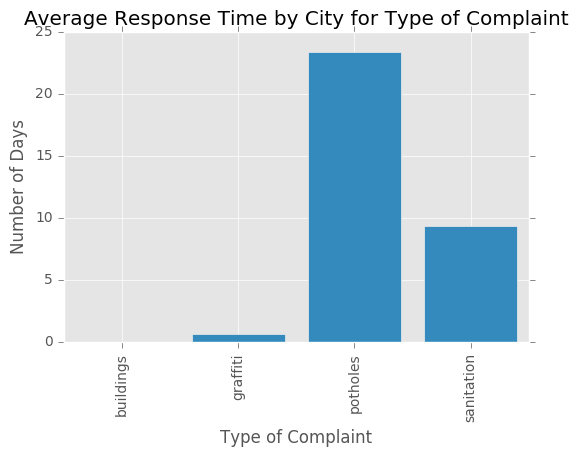

In [31]:
avg_response_dict = {"graffiti": np.mean(response_dict["Graffiti Removal"]),
                     "potholes": np.mean(response_dict["Pothole in Street"]),
                     "buildings": np.mean(response_dict["Vacant/Abandoned Building"]),
                     "sanitation": np.mean(response_dict["Sanitation Code Violation"])}

plt.bar(range(len(avg_response_dict)), avg_response_dict.values(), align='center')
plt.xticks(range(len(avg_response_dict)), avg_response_dict.keys(), rotation=90)
plt.title("Average Response Time by City for Type of Complaint")
plt.xlabel("Type of Complaint")
plt.ylabel("Number of Days")
plt.show()

Five interesting findings: 
- The city receives many more graffiti removal requests than potholes, vacant building, and sanitation complaints. More than twice as many as pothole requests, six times as many as sanitation code complaints, and 30 times as many as vacant building reports.
- Average response time for graffiti is almost three weeks faster than response time for potholes.
- Painted metal and brick and unpainted brick make up two-thirds of graffiti removal requests.
- Almost half of the sanitation code complaints subtypes are filed under the ambiguous "other" category.
- Approximately 60 percent of potholes eventually get patched within an average of three weeks.

In [47]:
def get_fips(df):        
    acs_df = pd.DataFrame()
    for row in df.itertuples():        
        lat = row[6]
        long = row[7]

        if str(lat) == 'nan':
            continue
        fcc_api_call = 'http://data.fcc.gov/api/block/find?format=json&latitude={}&longitude={}&showall=true'.format(lat,long)
        try:
            fcac = pd.read_json(fcc_api_call)
            fips = str(int(fcac['Block']['FIPS']))
        except ValueError:
            d = json.loads(requests.get(fcc_api_call).text)
            fips = pd.DataFrame(d['Block']['intersection'])['FIPS'][0]

        block_group = fips[-4]
        tract = fips[-10:-4]
        if fips == 'nan':
            continue
            
        df_addtract = pd.DataFrame(df.ix[row[0]]).transpose().reset_index().join(pd.DataFrame({'tract':tract, 'block group':block_group}, index=[0]))
        acs_df = pd.concat([acs_df, df_addtract])

    return acs_df

In [48]:
sorted_df = combined_df.sort('Creation Date')

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [57]:
result1 = pd.read_json('chicago_acs_all.json')
result1_tp = result1.transpose()

ValueError: Unexpected character found when decoding object value

In [60]:
result2 = get_fips(sorted_df.sample(n=1000))
result2 = result2.reset_index(drop=True)
result2 = pd.read_json('chicago_acs_sample.json')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [63]:
fcac = pd.read_json('http://data.fcc.gov/api/block/find?format=json&latitude=41.78437373&longitude=-87.71364839&showall=true')

In [59]:
response = urllib.request.urlopen('http://api.census.gov/data/2015/acs5?get=NAME,B02008_001E,B02009_001E,B02011_001E&for=block+group:*&in=state:17&in=county:031&in=tract:*&key=02483eaf62001ddc247c04dc50cfa681d83bce62')
html=response.read()
df = pd.read_json(html, typ='frame')
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df = df.rename(columns = new_header) #set the header row as the df header

In [52]:
merged_chicago_rand_acs = pd.merge(result,df, on=['block group','tract'], how = 'inner')

NameError: name 'result' is not defined

In [56]:
merged_chicago_acs = pd.merge(df, better_result_tp, on=['tract'], how = 'inner')

NameError: name 'better_result_tp' is not defined

In [53]:
merge_chicago_acs_name = merged_chicago_acs.rename(columns = {'B02008_001E':'white', 'B02009_001E':'black','B02011_001E':'asian'})

NameError: name 'merged_chicago_acs' is not defined

In [54]:
merge_chicago_rand = merged_chicago_rand_acs.rename(columns = {'B02008_001E':'white', 'B02009_001E':'black','B02011_001E':'asian'})

NameError: name 'merged_chicago_rand_acs' is not defined

In [67]:
is_wolcott = combined_df['Street Address'] == '7500 S WOLCOTT AVE'
is_wolcott2 = combined_df['STREET ADDRESS'] == '7500 S WOLCOTT AVE'
wolcott = combined_df[is_wolcott | is_wolcott2]
wolcott["Type of Service Request"]

4297     Sanitation Code Violation
23391            Pothole in Street
Name: Type of Service Request, dtype: object

The most likely service request from this address is a pothole or sanitation violation, with 0.5 probability of each. 

Honestly, I should have started this earlier. Sorry in advance.  